## Indoor Locationing Predictions using WiFi Fingerprinting
### Author: Mauricio Amoni

**Background**
Our client is developing a system to help people navigate a complex, unfamiliar interior space on a college campus.
They would like us to investigate the feasibility of using WiFi fingerprinting to determine a person's indoor location.
If a model meets or exceeds minimum specifications, it will be incorporated into a smart phone app for indoor locationing on a college campus.

Client Minimum Specifications
Indoor location must be as precise as predicting within 10-15 feet of the indoor room, also defined as ‘SpaceID’ within source data. Relative position, or whether individual is outside or inside of room, is unnecessary.

**Ideal performance metrics to achieve:**

- Accuracy scores on test data reaches 80% or higher
- Precision (accuracy of minority class) on test data reaches 80% or higher
- Recall (coverage of minority class) on test data is 80% or higher
- F1 Score for multi-class problem achieves 80% or higher

**Indoor localization has many use cases and exhibits great potential for solving problems in:**

- Indoor navigation for humans and robots
- Targeted advertising
- Emergency response
- Assisted living

In [218]:
# import libraries
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns
from pprint import pprint
import time

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
# magic word for producing visualizations in notebook
%matplotlib inline

# helpers
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# estimators
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import neighbors
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from scipy.sparse import lil_matrix

# model metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#Scoring Metrics
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import accuracy_score

In [53]:
df = pd.read_csv('/Users/mauricio/Downloads/UJIndoorLoc/trainingData.csv')

In [54]:
df.head(5)

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


## Evaluate Data

In [55]:
# check structure
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Data columns (total 529 columns):
 #    Column            Non-Null Count  Dtype  
---   ------            --------------  -----  
 0    WAP001            19937 non-null  int64  
 1    WAP002            19937 non-null  int64  
 2    WAP003            19937 non-null  int64  
 3    WAP004            19937 non-null  int64  
 4    WAP005            19937 non-null  int64  
 5    WAP006            19937 non-null  int64  
 6    WAP007            19937 non-null  int64  
 7    WAP008            19937 non-null  int64  
 8    WAP009            19937 non-null  int64  
 9    WAP010            19937 non-null  int64  
 10   WAP011            19937 non-null  int64  
 11   WAP012            19937 non-null  int64  
 12   WAP013            19937 non-null  int64  
 13   WAP014            19937 non-null  int64  
 14   WAP015            19937 non-null  int64  
 15   WAP016            19937 non-null  int64  
 16   WAP017            19

### Observations
Columns 0:520 have same structure, all are integers representing WiFi Access Points (WAP).
A new dataframe subsetting out 1 WAP and last 9 columns will be helpful
Notice no nulls

In [56]:
selected_columns = df.iloc[:,519:529]
selected_columns.head()

,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [57]:
# check structure
selected_columns.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WAP520            19937 non-null  int64  
 1   LONGITUDE         19937 non-null  float64
 2   LATITUDE          19937 non-null  float64
 3   FLOOR             19937 non-null  int64  
 4   BUILDINGID        19937 non-null  int64  
 5   SPACEID           19937 non-null  int64  
 6   RELATIVEPOSITION  19937 non-null  int64  
 7   USERID            19937 non-null  int64  
 8   PHONEID           19937 non-null  int64  
 9   TIMESTAMP         19937 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.5 MB


In [58]:
# summary statistics
selected_columns.describe()

,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,19937.0,19937.000000,1.993700e+04,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,100.0,-7464.275947,4.864871e+06,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,0.0,123.402010,6.693318e+01,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,100.0,-7691.338400,4.864746e+06,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,100.0,-7594.737000,4.864821e+06,1.000000,0.000000,110.000000,2.000000,5.000000,8.000000,1.371056e+09
50%,100.0,-7423.060900,4.864852e+06,2.000000,1.000000,129.000000,2.000000,11.000000,13.000000,1.371716e+09
75%,100.0,-7359.193000,4.864930e+06,3.000000,2.000000,207.000000,2.000000,13.000000,14.000000,1.371721e+09
max,100.0,-7300.818990,4.865017e+06,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.371738e+09


In [59]:
# check unique values for variables indicating a location

In [60]:
df['FLOOR'].unique()

array([2, 0, 3, 4, 1])

In [61]:
df['BUILDINGID'].nunique()

3

In [62]:
df['SPACEID'].nunique()

123

In [63]:
df['RELATIVEPOSITION'].nunique()

2

<AxesSubplot:>

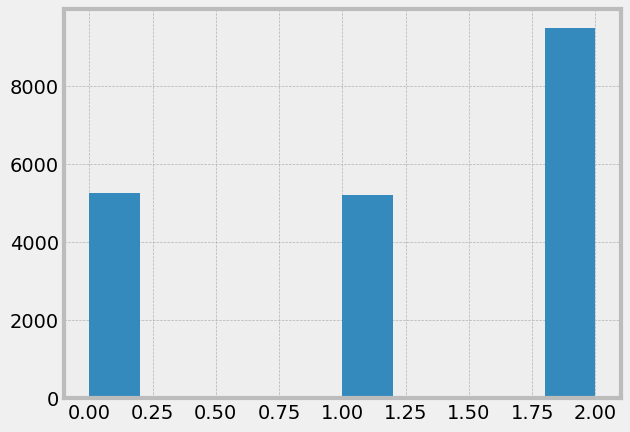

In [64]:
plt.style.use('bmh')
df['BUILDINGID'].hist()

**Note:**

The crowded building is the 3rd, 1st and 2nd are relatively similar 

<AxesSubplot:>

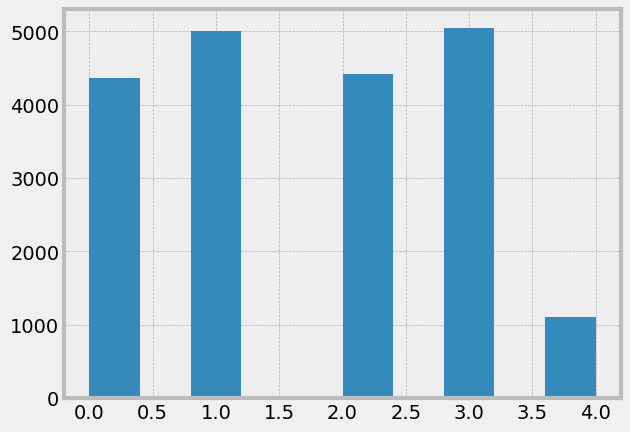

In [179]:
plt.style.use('bmh')
df['FLOOR'].hist()

Text(0.5, 1.0, 'Internal ID number. office, corridor, classroom')

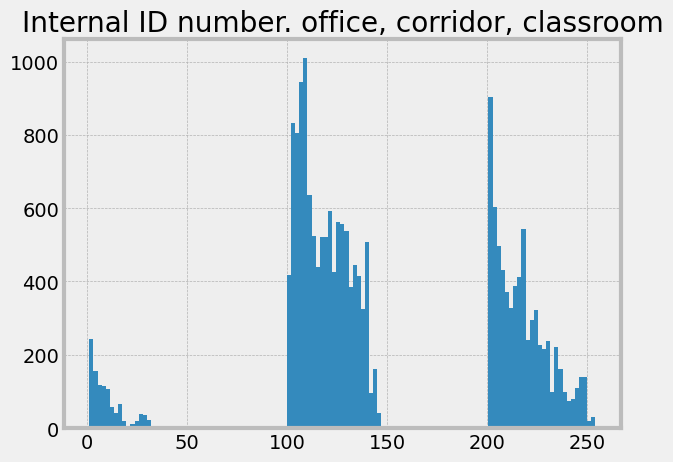

In [196]:
# histogram of SPACEID
plt.hist(df['SPACEID'], bins=123)
plt.title("Internal ID number. office, corridor, classroom)")

Text(0.5, 1.0, 'Signal Distribution')

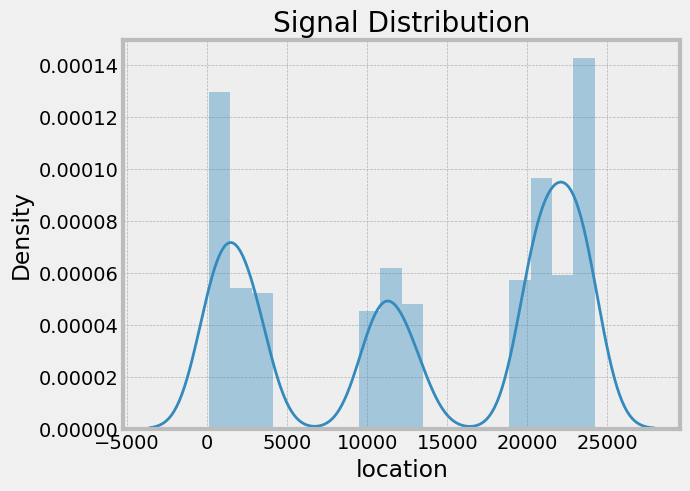

In [185]:
sns.distplot(df['location'])
plt.title("Signal Distribution")

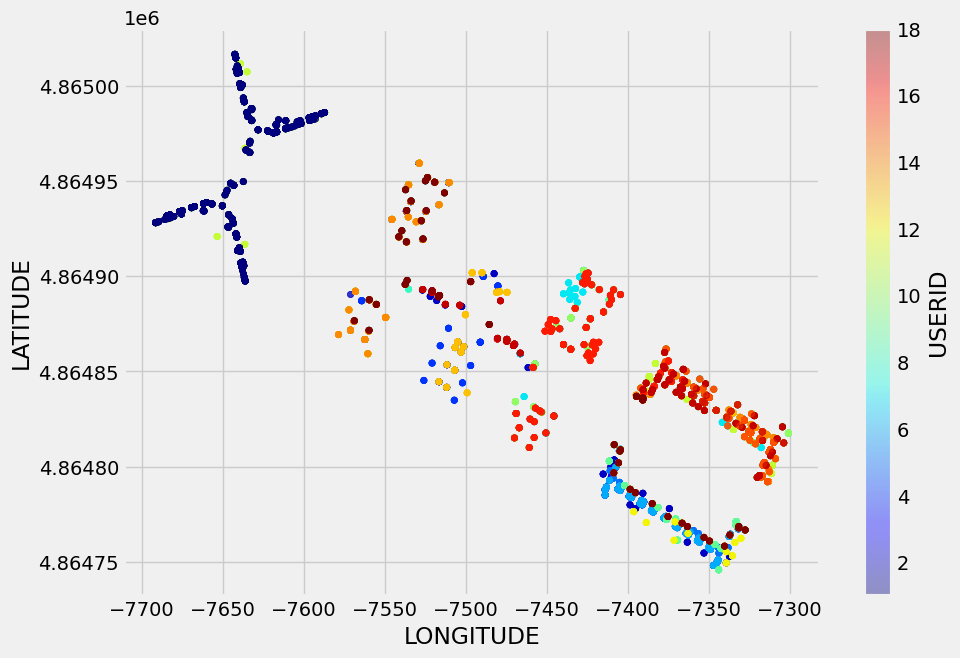

In [161]:
#map data by User ID

df.plot(kind="scatter", x="LONGITUDE", y="LATITUDE", alpha=0.4, figsize=(10,7),
    c="USERID", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.savefig('user_map2.png')

**Note**
This plot shown us an idea of the shape of the buildings from which we are colecting the daata

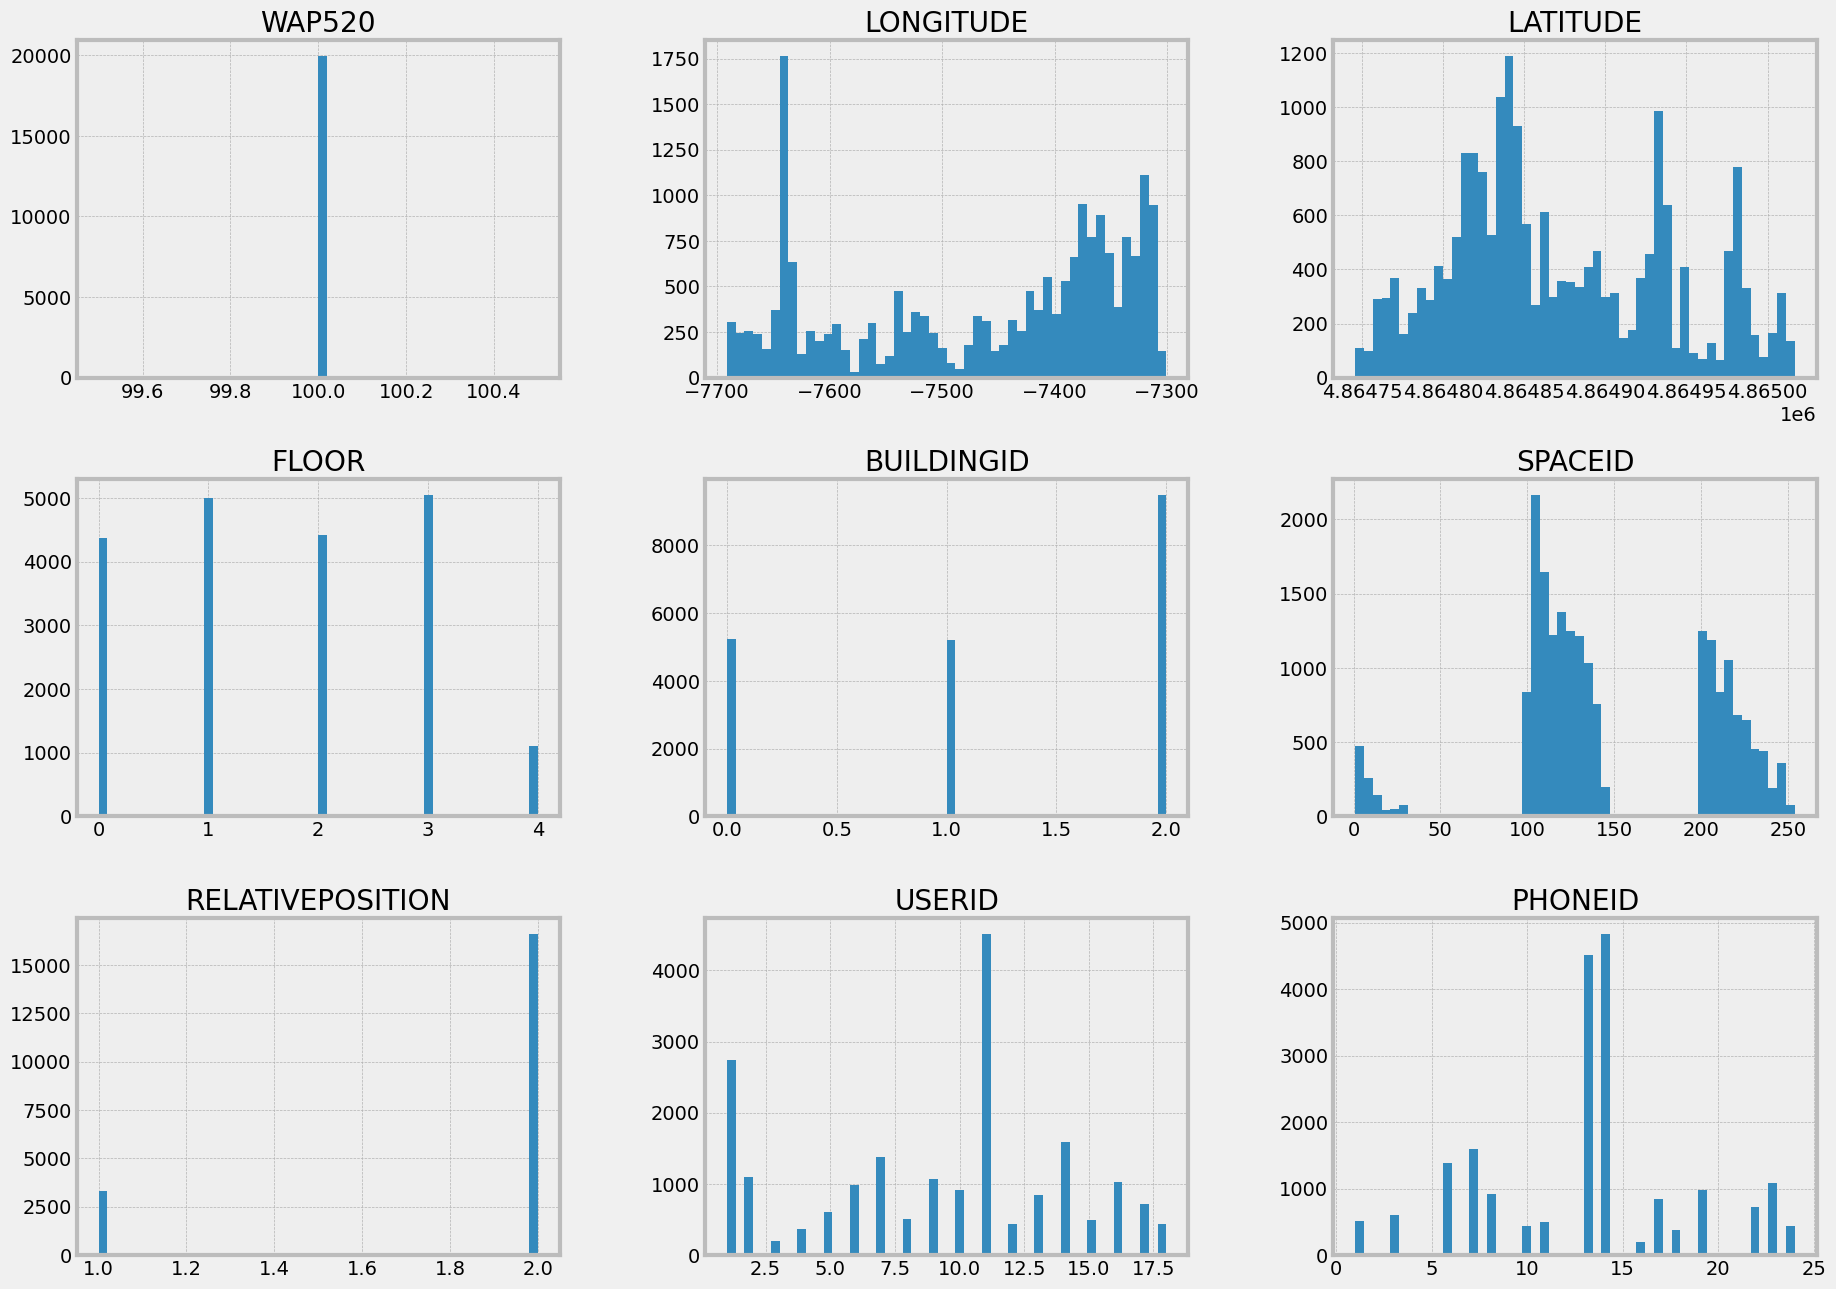

In [216]:
# plot the histograms of the attributes
df.iloc[:, 520:529].hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

**Comment:** 

The plots illustrate the distributions of the data. Most of the attributes have a multinomial distribution. The only variety presented in the distributions, is that of the Longitude and Latitude. Those values seem to have more a skewed normal distribution, however, those values if predicted alone cannot provide adequate information. 

In [220]:
attributes = ["BUILDINGID","FLOOR", "LATITUDE", "LONGITUDE", "SPACEID", "RELATIVEPOSITION"]
scatter_matrix(trainingData[attributes], figsize=(12, 8))
plt.savefig('matrix.png')

NameError: name 'scatter_matrix' is not defined

Text(0.5, 1.0, 'Correlation')

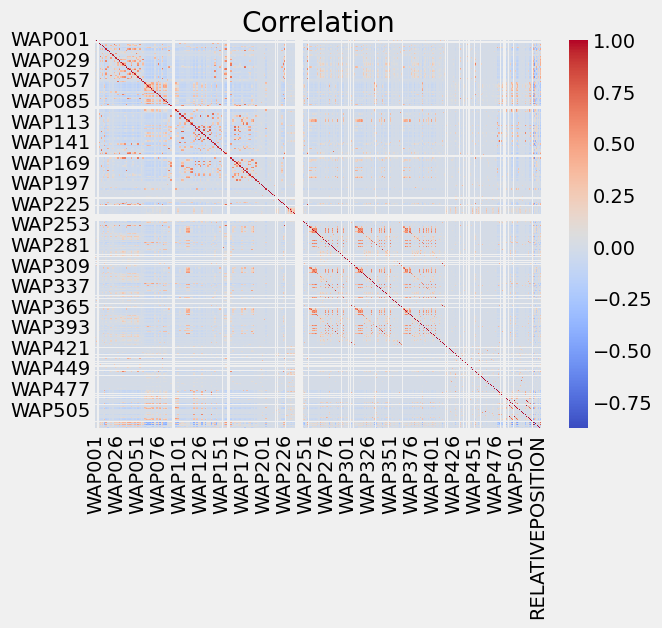

In [159]:
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('Correlation')

**Comment:** While checking the correlation between WAP inputs, we can see small pockets of correlation between the data. However, most of the data is not highly correlated and will not affect our classification accuracy. Nevertheless, to avoid the curse of dimentionality, I will reduce the number of features.

In [160]:
#pip install openpyxl

### Feature Engineering 

In [68]:
# create unique id for predicting specific campus location, as the dependent variable
df['location']=df['BUILDINGID'].astype(str)+''+df['FLOOR'].astype(str)+''+df['SPACEID'].astype(str)

In [69]:
df.head(5)

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,location
0,100,100,100,100,100,100,100,100,100,100,...,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733,12106
1,100,100,100,100,100,100,100,100,100,100,...,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691,12106
2,100,100,100,100,100,100,100,-97,100,100,...,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095,12103
3,100,100,100,100,100,100,100,100,100,100,...,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807,12102
4,100,100,100,100,100,100,100,100,100,100,...,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710,00122


In [70]:
df.location.nunique()

735

### Comments:
There are **735** different classes, or room locations, to predict. The Wifi Access Points will serve as the independent variables during algorithm training.

In [71]:
# move dependent variable 'location' to front for easy x and y identification
df = df[ ['location'] + [ col for col in df.columns if col != 'location'] ]

In [72]:
df.head()

,location,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,12106,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,12106,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,12103,100,100,100,100,100,100,100,-97,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,12102,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,00122,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


## Feature selection and sampling

#### Dataset 1: out-of-box (df1)

In [222]:
# drop any non-WAP variable (can only use WiFi Access Points as features)
df1 = df.drop(df.columns.to_series()['LONGITUDE':'TIMESTAMP'], axis=1)
df1['location'].nunique()

735

In [223]:
df1['location'].dtypes

dtype('O')

In [224]:
df1.head()

,location,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
0,12106,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
1,12106,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
2,12103,100,100,100,100,100,100,100,-97,100,...,100,100,100,100,100,100,100,100,100,100
3,12102,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
4,00122,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


Text(0.5, 1.0, 'Correlation')

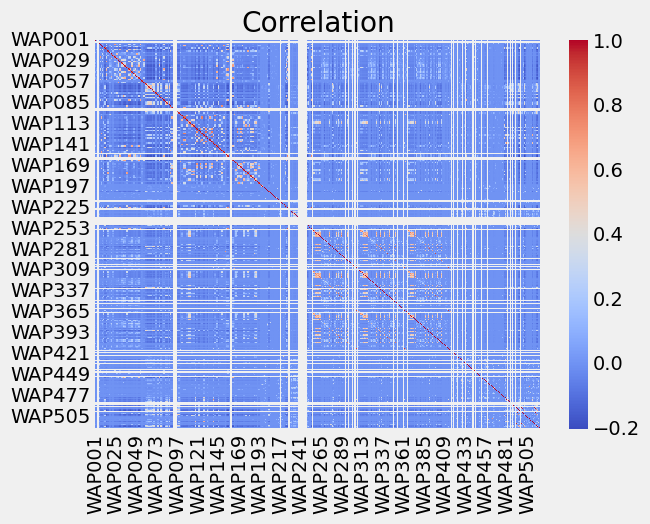

In [163]:
sns.heatmap(df1.corr(), cmap='coolwarm')
plt.title('Correlation')

### Sampling

Sample by building to see if metrics can be improved versus full **df1** dataset

### Dataset 2: Building_0

In [229]:
# BUILDINGID 0 only
Building_0 = df[df['BUILDINGID']==0]

In [230]:
# remove non-WAP columns
Building_0 = Building_0.drop(Building_0.columns.to_series()['LONGITUDE':'TIMESTAMP'], axis=1)
Building_0.head()

,location,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
4,00122,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
7119,00102,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
7120,00110,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
7121,00111,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
7122,00107,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


In [232]:
Building_0['location'].nunique()

256

In [233]:
Building_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5249 entries, 4 to 18497
Columns: 521 entries, location to WAP520
dtypes: int64(520), object(1)
memory usage: 20.9+ MB


**Observation:**

There are variables with only a single value of 100, aka zero variance variables. The data description tells us a value of 100 indicates no WiFi signal detection, therefore, columns with a single observation or value (100=no signal detection) are most likely useless for modeling.
I will remove zero variance variables from the sampled datasets.

In [234]:
# remove zero variance columns in Building0 dataset
nunique = Building_0.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index

In [235]:
Building_0 = Building_0.drop(cols_to_drop, axis=1)

In [236]:
Building_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5249 entries, 4 to 18497
Columns: 201 entries, location to WAP519
dtypes: int64(200), object(1)
memory usage: 8.1+ MB


In [237]:
Building_0.head(3)

,location,WAP001,WAP002,WAP007,WAP008,WAP009,WAP013,WAP014,WAP017,WAP018,...,WAP443,WAP447,WAP452,WAP459,WAP475,WAP494,WAP500,WAP508,WAP515,WAP519
4,00122,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
7119,00102,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
7120,00110,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


**Note:**

Building 0 dataset has 5249 row observations with 200 WAP columns (Independent Variables) and 1 Location column (Dependent Variable).

### Dataset 3: Building_1

In [238]:
Building_1 = df[df['BUILDINGID']==1]

In [239]:
Building_1.head(4)

,location,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,12106,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,12106,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,12103,100,100,100,100,100,100,100,-97,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,12102,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807


In [240]:
Building_1 = Building_1.drop(Building_1.columns.to_series()['LONGITUDE':'TIMESTAMP'], axis=1)

In [241]:
Building_1.head()

,location,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
0,12106,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
1,12106,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
2,12103,100,100,100,100,100,100,100,-97,100,...,100,100,100,100,100,100,100,100,100,100
3,12102,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
5,12105,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


In [243]:
Building_1['location'].nunique()

162

In [244]:
# remove zero variance columns in Building2 dataset
nunique = Building_1.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index

In [245]:
Building_1 = Building_1.drop(cols_to_drop, axis=1)

In [246]:
Building_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5196 entries, 0 to 19936
Columns: 208 entries, location to WAP503
dtypes: int64(207), object(1)
memory usage: 8.3+ MB


In [247]:
Building_1.head()

,location,WAP006,WAP008,WAP010,WAP011,WAP012,WAP015,WAP016,WAP017,WAP021,...,WAP439,WAP446,WAP449,WAP454,WAP468,WAP470,WAP478,WAP489,WAP490,WAP503
0,12106,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
1,12106,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
2,12103,100,-97,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
3,12102,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
5,12105,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


**Note:**

Building_1 dataset has 5196 row observations with 207 WAP columns (Independent Variables) and 1 Location column (Dependent Variable).

### Dataset 4: Building_2

In [248]:
Building_2 = df[df['BUILDINGID']==2]

In [250]:
Building_2.head()

,location,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
46,23247,100,100,100,100,100,100,100,100,100,...,100,-7331.748000,4.864767e+06,3,2,247,2,2,23,1371716690
47,23248,100,100,100,100,100,100,100,100,100,...,100,-7331.400500,4.864768e+06,3,2,248,2,2,23,1371716637
49,23247,100,100,100,100,100,100,100,100,100,...,100,-7327.492165,4.864767e+06,3,2,247,1,2,23,1371716719
50,23246,100,100,100,100,100,100,100,100,100,...,100,-7336.700400,4.864764e+06,3,2,246,2,2,23,1371716762
51,23245,100,100,100,100,100,100,100,100,100,...,100,-7337.394800,4.864763e+06,3,2,245,2,2,23,1371716797


In [251]:
Building_2 = Building_2.drop(Building_2.columns.to_series()['LONGITUDE':'TIMESTAMP'], axis=1)

In [252]:
Building_2.head()

,location,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
46,23247,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,-93,100,100,100
47,23248,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,-89,100,100,100
49,23247,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,-91,100,100
50,23246,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,-90,100,100,100
51,23245,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,-92,100,100,100


In [253]:
Building_2['location'].nunique()

317

In [256]:
# remove zero variance columns in Building2 dataset
nunique = Building_2.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique==1].index

In [257]:
Building_2= Building_2.drop(cols_to_drop, axis =1)

In [258]:
Building_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9492 entries, 46 to 19933
Columns: 204 entries, location to WAP518
dtypes: int64(203), object(1)
memory usage: 14.8+ MB


In [259]:
Building_2.head()

,location,WAP005,WAP006,WAP011,WAP012,WAP018,WAP059,WAP060,WAP061,WAP062,...,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP516,WAP517,WAP518
46,23247,100,100,100,100,100,-97,100,-85,-90,...,100,100,100,100,100,100,100,100,-93,100
47,23248,100,100,100,100,100,100,100,-84,-84,...,100,100,100,100,100,100,100,100,-89,100
49,23247,100,100,100,100,100,100,100,-89,-90,...,100,100,100,100,100,100,100,100,100,-91
50,23246,100,100,100,100,100,-97,100,-74,-72,...,100,100,100,100,100,100,100,100,-90,100
51,23245,100,100,100,100,100,100,100,-58,-58,...,100,100,100,100,100,100,100,100,-92,100


**Note:**

Building 2 dataset has 9492 row observations with 203 WAP columns (Independent Variables) and 1 Location column (Dependent Variable).

### Modeling: df1

Try 4 non-linear based algorithms:

- Decision Tree
- Random Forest
- Support Vector Machines RBF
- K Nearest Neighbors

In [76]:
# independent variable
X = df1.iloc[:,1:]

# dependent variable
y = df1['location']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [81]:
# prepare models
algos_Class = []
algos_Class.append(('Decision Tree', DecisionTreeClassifier(criterion='entropy')))
algos_Class.append(('Random Forest', RandomForestClassifier()))
algos_Class.append(('Support Vector Machines', SVC(kernel='rbf')))
algos_Class.append(('K Nearest Neighbors', KNeighborsClassifier()))

In [82]:
# filter warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [83]:
# evaluate each model in turn on df1
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)

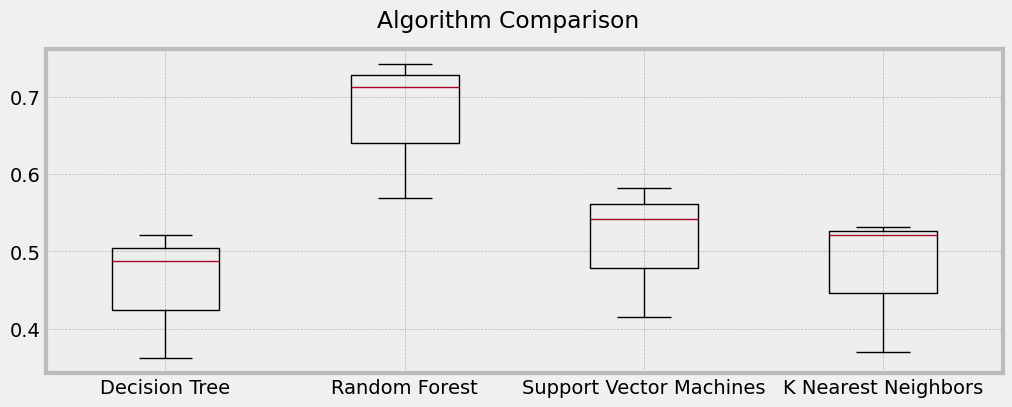

In [212]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,4))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Random Forest and Support Vector Machines are top two algorithms, therefore I will focuse on them to test the data 

In [87]:
# tune random forest
rf = RandomForestClassifier()

# parameters currently in use
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [94]:
# model tuning
rf = RandomForestClassifier(criterion='entropy', 
                            n_estimators=200,
                            n_jobs=-1,
                            random_state=123)
rf_df1 = rf.fit(X_train, y_train)

# predictions
y_preds = rf_df1.predict(X_test)
# assessment
print('Accuracy Score: '), accuracy_score(y_test, y_preds)

Accuracy Score: 


(None, 0.8079237713139418)

In [260]:
# evaluate metrics
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       00102       1.00      1.00      1.00         5
       00106       0.00      0.00      0.00         0
       00107       1.00      0.50      0.67         4
       00111       0.75      0.60      0.67         5
       00112       0.83      1.00      0.91         5
       00113       0.80      0.67      0.73         6
       00114       1.00      1.00      1.00         3
       00115       1.00      0.86      0.92         7
       00116       0.80      0.80      0.80         5
       00117       0.50      0.33      0.40         3
       00118       0.80      1.00      0.89         4
       00119       0.70      0.88      0.78         8
       00120       1.00      1.00      1.00        12
       00121       0.88      0.88      0.88         8
       00122       1.00      0.75      0.86         8
       00123       0.38      1.00      0.55         3
       00125       0.86      1.00      0.92         6
       00126       1.00    

In [89]:
# Random Forest df1 metrics compiled
print(('Accuracy: '), accuracy_score(y_test, y_preds))
print(('Precision: '), precision_score(y_test, y_preds, average='weighted'))
print(('Recall: '), recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds)))
print(('F1: '), f1_score(y_test, y_preds, average='weighted'))

Accuracy:  0.8079237713139418
Precision:  0.852607130021112
Recall:  0.8110421211612686
F1:  0.8092273282041701


**Notes:**

Although accuracy is a useful metric, for this problem, recall is also important. Recall gauges how many spaces our model correctly classifies (True Positives) out of all Actual Positives within each class. There is a high cost associated with a False Negative (incorrect room prediction) when being considered for deploying in a Smart Phone app. To get another sense of how well our model did, we will sum the number of spaces that fall within Recall quartiles and compare at the very end.

In [263]:
# create dataframe of metrics
RF_df1 = pd.DataFrame([accuracy_score(y_test, y_preds),
                       precision_score(y_test, y_preds, average='weighted'),
                       recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds)),
                       f1_score(y_test, y_preds, average='weighted')])

# rename column and indexes
RF_df1 = RF_df1.rename(columns={0: 'RF_df1'},
                        index={0: 'Accuracy', 1: 'Precision (weighted)', 2: 'Recall (weighted)', 3: 'F1 (weighted)'})

RF_df1.head()

,RF_df1
Accuracy,0.807924
Precision (weighted),0.852607
Recall (weighted),0.811042
F1 (weighted),0.809227


In [262]:
# compare RF recall counts by quartile
rf_df1_recall = pd.DataFrame(recall_score(y_test, y_preds, average=None))
rf_df1_recall.head(10)

,0
0,1.000000
1,0.000000
2,0.500000
3,0.600000
4,1.000000
5,0.666667
6,1.000000
7,0.857143
8,0.800000
9,0.333333


In [265]:
rf_df1_quartile = pd.DataFrame(rf_df1_recall[0].value_counts(bins=4, sort=False))

# rename column
rf_df1_quartile = rf_df1_quartile.rename(columns={0: 'df1'})

rf_df1_quartile.head()

,df1
"(-0.002, 0.25]",22
"(0.25, 0.5]",85
"(0.5, 0.75]",171
"(0.75, 1.0]",453


In [198]:
# Dataframe comparing predictions to y_test 'ground truth'
y_test = pd.DataFrame(y_test)
y_test.head()

# predictions dataframe
y_preds = pd.DataFrame(y_preds)
# rename prediction column
y_preds = y_preds.rename(columns={0: 'RFpreds_df1'})

# comparison dataframe
rf_compare_df1 = pd.concat([y_test, y_preds.set_index(y_test.index)], axis=1)
rf_compare_df1.head(10)

,location,RFpreds_df1
6195,12202,12202
13675,23121,23121
16554,03225,03225
222,12101,12101
1550,125,125
5386,13201,13201
15355,10248,10248
10625,11109,11109
12827,103,101
17404,00230,00230


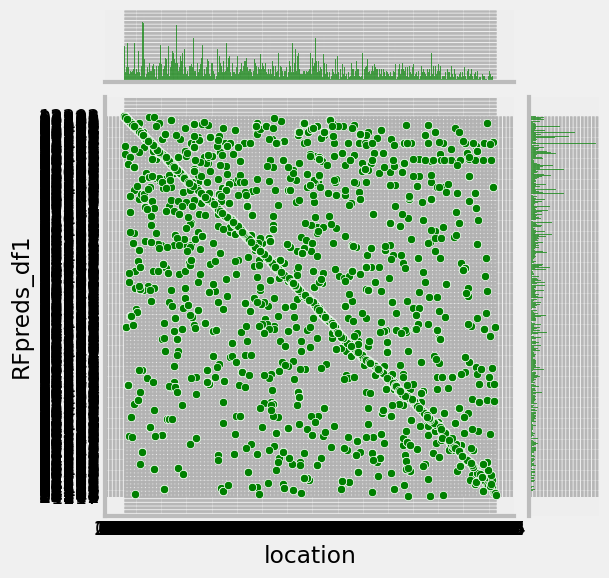

In [199]:
sns.jointplot(x='location', y='RFpreds_df1', data=rf_compare_df1,color='green')

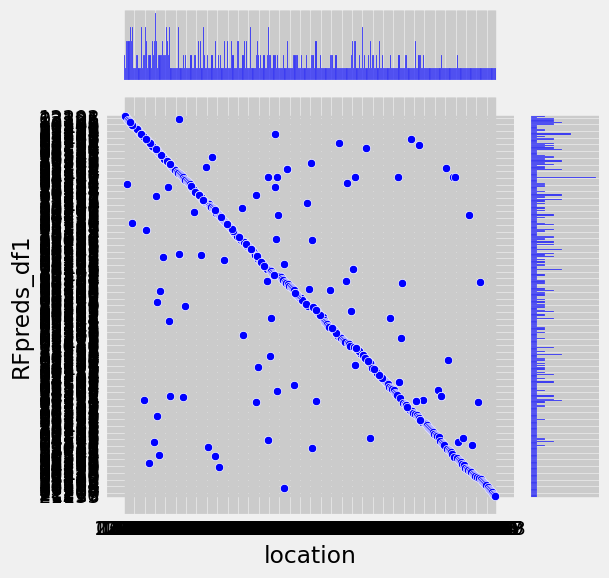

In [118]:
sns.jointplot(x='location', y='RFpreds_df1', data=rf_compare_df1.head(500),color='blue')

In [266]:
# tune SVC on df1
svc = SVC()

# parameters currently in use
pprint(svc.get_params())

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [267]:
# manual tuning
param_grid = {
    'C': [1, 10, 100, 1000]
}

In [268]:
gs_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, n_jobs=-1)
gs_svc.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000]})

In [270]:
gs_svc.best_params_

{'C': 10}

In [271]:
# model tuning
svc = SVC(C=10, random_state=123)
svc_df1 = svc.fit(X_train, y_train)

# predictions
y_preds = svc_df1.predict(X_test)
# assessment
print('Accuracy Score: '), accuracy_score(y_test, y_preds)

Accuracy Score: 


(None, 0.6905717151454364)

In [272]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       00102       1.00      1.00      1.00         5
       00106       0.00      0.00      0.00         0
       00107       1.00      0.75      0.86         4
       00110       0.00      0.00      0.00         0
       00111       0.33      0.20      0.25         5
       00112       0.25      0.40      0.31         5
       00113       0.18      0.33      0.24         6
       00114       0.75      1.00      0.86         3
       00115       0.83      0.71      0.77         7
       00116       0.67      0.80      0.73         5
       00117       0.33      0.33      0.33         3
       00118       0.50      0.75      0.60         4
       00119       0.67      0.75      0.71         8
       00120       0.60      0.75      0.67        12
       00121       0.50      0.12      0.20         8
       00122       0.33      0.25      0.29         8
       00123       0.67      0.67      0.67         3
       00125       0.80    

In [273]:
# svc df1 metrics compiled
print(('Accuracy: '), accuracy_score(y_test, y_preds))
print(('Precision: '), precision_score(y_test, y_preds, average='weighted'))
print(('Recall: '), recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds)))
print(('F1: '), f1_score(y_test, y_preds, average='weighted'))

Accuracy:  0.6905717151454364
Precision:  0.7377544366993499
Recall:  0.6937027707808564
F1:  0.6926430719618486


In [274]:

# create dataframe of metrics
SVC_df1 = pd.DataFrame([accuracy_score(y_test, y_preds),
                       precision_score(y_test, y_preds, average='weighted'),
                       recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds)),
                       f1_score(y_test, y_preds, average='weighted')])

# rename column and indexes
SVC_df1 = SVC_df1.rename(columns={0: 'SVC_df1'},
                        index={0: 'Accuracy', 1: 'Precision (weighted)', 2: 'Recall (weighted)', 3: 'F1 (weighted)'})

SVC_df1.head()

,SVC_df1
Accuracy,0.690572
Precision (weighted),0.737754
Recall (weighted),0.693703
F1 (weighted),0.692643


In [275]:
# create dataframe comparing predictions to y_test 'ground truth'
y_test = pd.DataFrame(y_test)
y_test.head()

# predictions dataframe
y_preds = pd.DataFrame(y_preds)
# rename prediction column
y_preds = y_preds.rename(columns={0: 'SVCpreds_df1'})

# comparison dataframe
svc_df1_compare = pd.concat([y_test, y_preds.set_index(y_test.index)], axis=1)
svc_df1_compare.head(10)

,location,SVCpreds_df1
6195,12202,12202
13675,23121,23121
16554,03225,03221
222,12101,12101
1550,125,125
5386,13201,13201
15355,10248,10248
10625,11109,11109
12827,103,101
17404,00230,00230



## Overall Results df1

**Random Forest**
- Accuracy:  0.8079237713139418
- Precision:  0.852607130021112
- Recall:  0.8110421211612686
- F1:  0.8092273282041701

**SVC**
- Accuracy:  0.6905717151454364
- Precision:  0.7377544366993499
- Recall:  0.6937027707808564
- F1:  0.6926430719618486

### Random Forest is the best model for df1 dataset

## Modeling Buildings Individualy

### Building_0

Test 4 algorithms:

- Decision Tree
- Random Forest
- Support Vector Machines RBF
- K Nearest Neighbors

In [276]:
# Independent variables
X = Building_0.iloc[:,1:]

# Dependent variable
y = Building_0['location']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 123)

In [277]:
# prepare models
algos_Class = []
algos_Class.append(('Decision Tree', DecisionTreeClassifier()))
algos_Class.append(('Random Forest', RandomForestClassifier()))
algos_Class.append(('Support Vector', SVC(kernel='rbf')))
algos_Class.append(('K Nearest Neighbors', KNeighborsClassifier()))

In [278]:
# evaluate each model in turn on Building0
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)
    
# cross validation results
for i in range(len(names)):
    print(names[i], results[i].mean(), results[i].std())

Decision Tree 0.4330697813716681 0.1631752269569697
Random Forest 0.6792235018650112 0.2115426179193675
Support Vector 0.4557439625364153 0.18261042239650624
K Nearest Neighbors 0.43422200441068365 0.19887551867467318


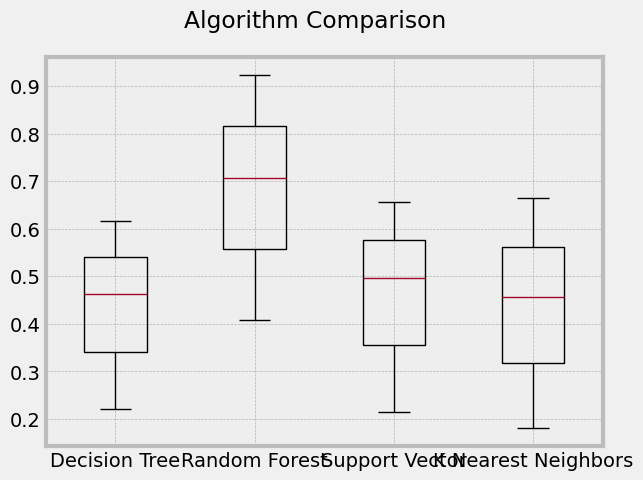

In [290]:
# boxplot algorithm comparison

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [291]:
# model tuning random forest Building_0
rfB0 = RandomForestClassifier(criterion='entropy',
                              n_estimators=200,
                              n_jobs=-1,
                             random_state=123)
rf_B0 = rfB0.fit(X_train, y_train)

# predictions
y_preds = rf_B0.predict(X_test)
# assessment
print('Accuracy Score: '), accuracy_score(y_test, y_preds)

Accuracy Score: 


(None, 0.7677075399847677)

In [292]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       00102       1.00      1.00      1.00         5
       00106       1.00      1.00      1.00         1
       00107       1.00      1.00      1.00         1
       00110       1.00      0.75      0.86         4
       00111       0.75      0.75      0.75         4
       00112       1.00      0.75      0.86         4
       00113       1.00      0.88      0.93         8
       00114       1.00      0.67      0.80         3
       00115       0.50      0.75      0.60         4
       00116       0.67      0.40      0.50         5
       00117       0.00      0.00      0.00         0
       00118       0.75      0.60      0.67         5
       00119       1.00      0.62      0.77         8
       00120       0.62      1.00      0.76         8
       00121       1.00      0.62      0.77         8
       00122       1.00      0.67      0.80         6
       00123       0.57      1.00      0.73         4
       00125       0.00    

In [293]:
# Random Forest Building 0 metrics compiled
print(('Accuracy: '), accuracy_score(y_test, y_preds))
print(('Precision: '), precision_score(y_test, y_preds, average='weighted'))
print(('Recall: '), recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds), zero_division=1))
print(('F1: '), f1_score(y_test, y_preds, average='weighted'))

Accuracy:  0.7677075399847677
Precision:  0.815282760313225
Recall:  0.7694656488549618
F1:  0.766309817116171


In [294]:
# create dataframe of metrics
RF_B0 = pd.DataFrame([accuracy_score(y_test, y_preds),
                      precision_score(y_test, y_preds, average='weighted'),
                      recall_score(y_test, y_preds, average='weighted', zero_division=1),
                     f1_score(y_test, y_preds, average='weighted')])

# rename column and indexes
RF_B0 = RF_B0.rename(columns={0: 'RF_B0'},
                     index={0: 'Accuracy',
                            1: 'Precision (weighted)',
                            2: 'Recall (weighted)',
                            3: 'F1 (weighted)'})

RF_B0.head()

,RF_B0
Accuracy,0.767708
Precision (weighted),0.815283
Recall (weighted),0.767708
F1 (weighted),0.766310


In [295]:
# compare RF recall counts by quartile
rf_B0_recall = pd.DataFrame(recall_score(y_test, y_preds, average=None))
rf_B0_recall.head(10)

,0
0,1.000000
1,1.000000
2,1.000000
3,0.750000
4,0.750000
5,0.750000
6,0.875000
7,0.666667
8,0.750000
9,0.400000


In [296]:
rf_B0_quartile = pd.DataFrame(rf_B0_recall[0].value_counts(bins=4, sort=False))

# rename column
rf_B0_quartile = rf_B0_quartile.rename(columns={0: 'Building_0'})

rf_B0_quartile.head()

,Building_0
"(-0.002, 0.25]",5
"(0.25, 0.5]",40
"(0.5, 0.75]",70
"(0.75, 1.0]",141


In [297]:
# manual tuning support vector Building 0
param_grid = {
    'C': [1, 10, 100, 1000]
}

In [298]:
gs_svcB0 = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, n_jobs=-1)
gs_svcB0.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(C=10, random_state=123), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000]})

In [299]:
gs_svcB0.best_params_

{'C': 1000}

In [ ]:
gs_svcB0.best_params_

In [300]:
# model tuning support vector Building 0
svcB0 = SVC(C=1000, random_state=123)
svc_B0 = svcB0.fit(X_train, y_train)

# predictions
y_preds = svc_B0.predict(X_test)
# assessment
print('Accuracy Score: '), accuracy_score(y_test, y_preds)

Accuracy Score: 


(None, 0.6153846153846154)

In [301]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       00102       1.00      0.80      0.89         5
       00106       0.50      1.00      0.67         1
       00107       0.00      0.00      0.00         1
       00110       0.67      1.00      0.80         4
       00111       0.25      0.25      0.25         4
       00112       0.60      0.75      0.67         4
       00113       0.83      0.62      0.71         8
       00114       0.67      0.67      0.67         3
       00115       0.43      0.75      0.55         4
       00116       0.50      0.40      0.44         5
       00117       0.00      0.00      0.00         0
       00118       1.00      0.40      0.57         5
       00119       0.86      0.75      0.80         8
       00120       0.70      0.88      0.78         8
       00121       1.00      0.38      0.55         8
       00122       0.25      0.17      0.20         6
       00123       0.33      0.50      0.40         4
       00125       0.00    

In [302]:
# svc B0 metrics compiled
print(('Accuracy: '), accuracy_score(y_test, y_preds))
print(('Precision: '), precision_score(y_test, y_preds, average='weighted'))
print(('Recall: '), recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds)))
print(('F1: '), f1_score(y_test, y_preds, average='weighted'))

Accuracy:  0.6153846153846154
Precision:  0.6702198622229086
Recall:  0.6210607225211375
F1:  0.6141644927115418


In [303]:
# create dataframe of metrics
SVC_B0 = pd.DataFrame([accuracy_score(y_test, y_preds),
                       precision_score(y_test, y_preds, average='weighted'),
                       recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds)),
                       f1_score(y_test, y_preds, average='weighted')])

# rename column and indexes
SVC_B0 = SVC_B0.rename(columns={0: 'SVC_B0'},
                        index={0: 'Accuracy', 1: 'Precision (weighted)', 2: 'Recall (weighted)', 3: 'F1 (weighted)'})

SVC_B0.head()

,SVC_B0
Accuracy,0.615385
Precision (weighted),0.670220
Recall (weighted),0.621061
F1 (weighted),0.614164


In [304]:
# create dataframe comparing predictions to y_test 'ground truth'
y_test = pd.DataFrame(y_test)
y_test.head()

# predictions dataframe
y_preds = pd.DataFrame(y_preds)
# rename prediction column
y_preds = y_preds.rename(columns={0: 'SVCpreds_B0'})

# comparison dataframe
svc_B0_compare = pd.concat([y_test, y_preds.set_index(y_test.index)], axis=1)
svc_B0_compare.head(10)

,location,SVCpreds_B0
18076,01136,01136
15848,01124,01124
16153,01130,01130
18150,03106,03106
8069,01235,00222
18006,01108,01108
17902,03131,03131
15958,02140,02140
10271,00118,00116
9883,01221,01224


### Building_0 Overall Results

**Random Forest**
- Accuracy:  0.7677075399847677
- Precision:  0.815282760313225
- Recall:  0.7694656488549618
- F1:  0.766309817116171

**SVC**
- Accuracy: 0.6153846153846154
- Precision: 0.6702198622229086
- Recall: 0.6210607225211375
- F1: 0.6141644927115418

#### Random Forest is top model for Building_0 dataset

- Metrics are not quite as high as metrics for df1 dataset

### Building _1
Try 4 algorithms:
- Decision Tree
- Random Forest
- Support Vector Machines RBF
- K Nearest Neighbors

In [306]:
# independent
X = Building_1.iloc[:,1:]

# dependent variable
y = Building_1['location']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 123)

In [307]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3897 entries, 1407 to 12695
Columns: 207 entries, WAP006 to WAP503
dtypes: int64(207)
memory usage: 6.2 MB


In [308]:
y_train.head()

1407       124
6514     13217
19415     1313
14937    10247
4263     10229
Name: location, dtype: object

In [309]:
# prepare models
algos_Class = []
algos_Class.append(('Decision Tree', DecisionTreeClassifier(criterion='entropy')))
algos_Class.append(('Random Forest', RandomForestClassifier()))
algos_Class.append(('Support Vector', SVC(kernel='rbf')))
algos_Class.append(('K Nearest Neighbors', KNeighborsClassifier()))

In [310]:
# evaluate each model in turn on Building_1
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)

In [311]:
# cross validation results
for i in range(len(names)):
    print(names[i], results[i].mean(), results[i].std())

Decision Tree 0.6198999230177059 0.04499350021925313
Random Forest 0.7892609699769052 0.04045143037715437
Support Vector 0.6272132409545804 0.04136768763909716
K Nearest Neighbors 0.5871824480369515 0.04955950054012687


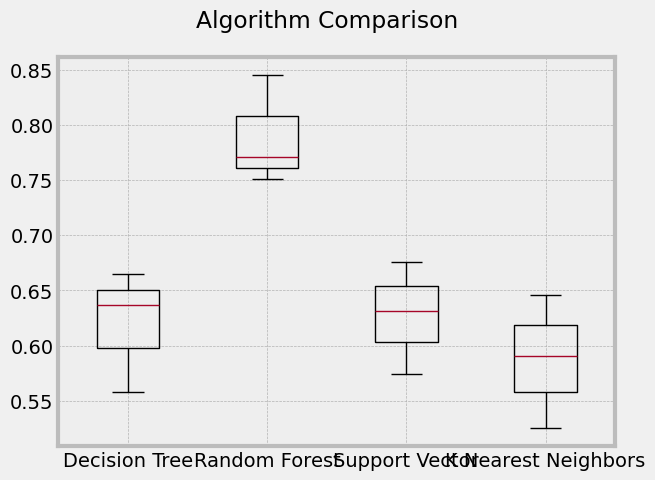

In [312]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Random Forrest top model for Building_1

In [313]:
# model tuning
rfB1 = RandomForestClassifier(criterion='entropy',
                              n_estimators=400,
                              n_jobs=-1,
                             random_state=123)
rf_B1 = rfB1.fit(X_train, y_train)

# predictions
y_preds = rf_B1.predict(X_test)
# assessment
print('Accuracy Score: '), accuracy_score(y_test, y_preds)

Accuracy Score: 


(None, 0.8791377983063895)

In [314]:

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         101       0.89      1.00      0.94         8
        1010       1.00      0.88      0.93         8
       10107       1.00      1.00      1.00         5
       10108       0.83      1.00      0.91         5
       10110       1.00      0.75      0.86         4
       10111       1.00      1.00      1.00         2
       10112       0.70      1.00      0.82         7
       10113       0.75      0.50      0.60         6
       10114       1.00      0.83      0.91         6
       10115       1.00      1.00      1.00         2
       10116       0.86      1.00      0.92         6
       10117       1.00      0.80      0.89         5
       10118       1.00      1.00      1.00         3
       10119       1.00      1.00      1.00         6
       10121       1.00      1.00      1.00         2
       10122       1.00      1.00      1.00         5
        1015       1.00      1.00      1.00         3
        1016       1.00    

In [315]:
# Random Forest Building 1 metrics compiled
print(('Accuracy: '), accuracy_score(y_test, y_preds))
print(('Precision: '), precision_score(y_test, y_preds, average='weighted'))
print(('Recall: '), recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds), zero_division=1))
print(('F1: '), f1_score(y_test, y_preds, average='weighted'))

Accuracy:  0.8791377983063895
Precision:  0.8950421538198201
Recall:  0.8852713178294573
F1:  0.8766795872718322


In [316]:
# create dataframe of metrics
RF_B1 = pd.DataFrame([accuracy_score(y_test, y_preds),
                      precision_score(y_test, y_preds, average='weighted'),
                      recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds), zero_division=1),
                     f1_score(y_test, y_preds, average='weighted')])

In [317]:
# rename column and indexes
RF_B1 = RF_B1.rename(columns={0: 'RF_B1'},
                     index={0: 'Accuracy',
                            1: 'Precision (weighted)',
                            2: 'Recall (weighted)',
                            3: 'F1 (weighted)'})

RF_B1.head()

,RF_B1
Accuracy,0.879138
Precision (weighted),0.895042
Recall (weighted),0.885271
F1 (weighted),0.876680


In [318]:
# compare RF recall counts by quartile
rf_B1_recall = pd.DataFrame(recall_score(y_test, y_preds, average=None))
rf_B1_recall.head(10)

,0
0,1.000000
1,0.875000
2,1.000000
3,1.000000
4,0.750000
5,1.000000
6,1.000000
7,0.500000
8,0.833333
9,1.000000


In [319]:
rf_B1_quartile = pd.DataFrame(rf_B1_recall[0].value_counts(bins=4, sort=False))

# rename column
rf_B1_quartile = rf_B1_quartile.rename(columns={0: 'Building 1'})

rf_B1_quartile.head()

,Building 1
"(-0.002, 0.25]",4
"(0.25, 0.5]",13
"(0.5, 0.75]",18
"(0.75, 1.0]",125


In [320]:
# manual tuning SVC Building 1
param_grid = {
    'C': [1, 10, 100, 1000]
}

In [321]:
gs_svcB1 = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, n_jobs=-1)
gs_svcB1.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(C=10, random_state=123), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000]})

In [322]:
gs_svcB1.best_params_

{'C': 1000}

In [323]:
# model tuning
svcB1 = SVC(C=1000, random_state=123)
svc_B1 = svcB1.fit(X_train, y_train)

# predictions
y_preds = svc_B1.predict(X_test)
# assessment
print('Accuracy Score: '), accuracy_score(y_test, y_preds)

Accuracy Score: 


(None, 0.7428791377983064)

In [324]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         101       0.89      1.00      0.94         8
        1010       0.75      0.75      0.75         8
       10107       0.80      0.80      0.80         5
       10108       1.00      0.40      0.57         5
       10110       1.00      0.50      0.67         4
       10111       0.40      1.00      0.57         2
       10112       0.36      0.57      0.44         7
       10113       0.75      0.50      0.60         6
       10114       0.67      1.00      0.80         6
       10115       1.00      1.00      1.00         2
       10116       1.00      1.00      1.00         6
       10117       1.00      1.00      1.00         5
       10118       0.75      1.00      0.86         3
       10119       0.86      1.00      0.92         6
       10121       1.00      0.50      0.67         2
       10122       0.83      1.00      0.91         5
        1015       1.00      1.00      1.00         3
        1016       1.00    

In [325]:
# svc B1 metrics compiled
print(('Accuracy: '), accuracy_score(y_test, y_preds))
print(('Precision: '), precision_score(y_test, y_preds, average='weighted'))
print(('Recall: '), recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds), zero_division=1))
print(('F1: '), f1_score(y_test, y_preds, average='weighted'))

Accuracy:  0.7428791377983064
Precision:  0.7662663459619411
Recall:  0.7474825716498839
F1:  0.7396721719869349


In [326]:
# create dataframe of metrics
SVC_B1 = pd.DataFrame([accuracy_score(y_test, y_preds),
                       precision_score(y_test, y_preds, average='weighted'),
                       recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds), zero_division=1),
                       f1_score(y_test, y_preds, average='weighted')])

# rename column and indexes
SVC_B1 = SVC_B1.rename(columns={0: 'SVC_B1'},
                        index={0: 'Accuracy', 1: 'Precision (weighted)', 2: 'Recall (weighted)', 3: 'F1 (weighted)'})

SVC_B1.head()

,SVC_B1
Accuracy,0.742879
Precision (weighted),0.766266
Recall (weighted),0.747483
F1 (weighted),0.739672


### Building 1 Overall Results

**Random Forest**
- Accuracy: 0.8791377983063895
- Precision: 0.8950421538198201
- Recall: 0.8852713178294573
- F1: 0.8766795872718322

**SVC**
- Accuracy: 0.7428791377983064
- Precision: 0.7662663459619411
- Recall: 0.7474825716498839
- F1: 0.7396721719869349

#### Random Forest is top model for Building 1 dataset
Metrics are higher than df1 dataset

#### Building 2

Try 4 algorithms:
- Decision Tree
- Random Forest
- Support Vector Machines RBF
- K Nearest Neighbors

In [327]:
# features
X = Building_2.iloc[:,1:]

# target variable
y = Building_2['location']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 123)

In [328]:
# prepare models
algos_Class = []
algos_Class.append(('Decision Tree', DecisionTreeClassifier()))
algos_Class.append(('Random Forest', RandomForestClassifier()))
algos_Class.append(('Support Vector', SVC(kernel='rbf')))
algos_Class.append(('K Nearest Neighbors', KNeighborsClassifier()))

In [329]:
# evaluate each model in turn on Building2
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    names.append(name)
    results.append(result)

In [330]:
# cross validation results Building 2
for i in range(len(names)):
    print(names[i], results[i].mean(), results[i].std())

Decision Tree 0.390117994100295 0.06157075816301075
Random Forest 0.6185208596713022 0.07411128158530274
Support Vector 0.503898019384745 0.06716576589553282
K Nearest Neighbors 0.435630004214075 0.05532708976602161


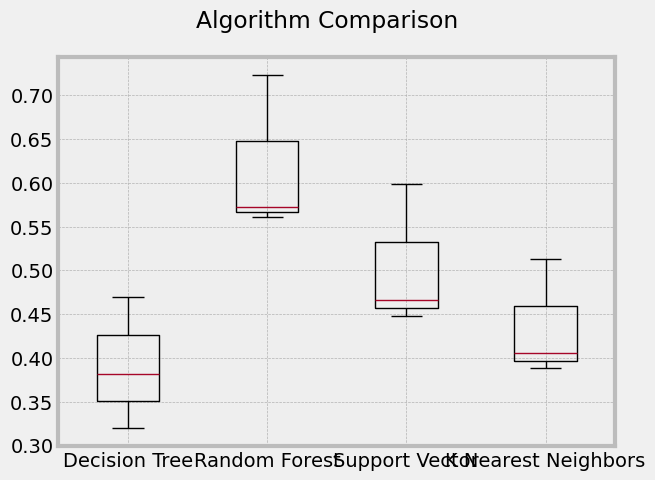

In [331]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Random Forest is the best model for Building_2

In [332]:
# model tuning random forest Building 2
rfB2 = RandomForestClassifier(criterion='entropy',
                              n_estimators=600,
                              n_jobs=-1,
                             random_state=123)
rf_B2 = rfB2.fit(X_train, y_train)

# predictions
y_preds = rf_B2.predict(X_test)
# assessment
print('Accuracy Score: '), accuracy_score(y_test, y_preds)

Accuracy Score: 


(None, 0.8238516645596292)

In [333]:
# Random Forest Building_2 metrics compiled
print(('Accuracy: '), accuracy_score(y_test, y_preds))
print(('Precision: '), precision_score(y_test, y_preds, average='weighted'))
print(('Recall: '), recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds), zero_division=1))
print(('F1: '), f1_score(y_test, y_preds, average='weighted'))

Accuracy:  0.8238516645596292
Precision:  0.8905551274694012
Recall:  0.8245466048080978
F1:  0.8325727025030154


In [334]:
# create dataframe of metrics
RF_B2 = pd.DataFrame([accuracy_score(y_test, y_preds),
                      precision_score(y_test, y_preds, average='weighted'),
                      recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds), zero_division=1),
                     f1_score(y_test, y_preds, average='weighted')])

# rename column and indexes
RF_B2 = RF_B2.rename(columns={0: 'RF_B2'},
                     index={0: 'Accuracy',
                            1: 'Precision (weighted)',
                            2: 'Recall (weighted)',
                            3: 'F1 (weighted)'})

RF_B2.head()

,RF_B2
Accuracy,0.823852
Precision (weighted),0.890555
Recall (weighted),0.824547
F1 (weighted),0.832573


In [335]:
# compare RF recall counts by quartile
rf_B2_recall = pd.DataFrame(recall_score(y_test, y_preds, average=None))
rf_B2_recall.head(10)

,0
0,0.750000
1,0.769231
2,0.933333
3,0.857143
4,0.818182
5,1.000000
6,0.700000
7,0.916667
8,1.000000
9,1.000000


In [336]:
rf_B2_quartile = pd.DataFrame(rf_B2_recall[0].value_counts(bins=4, sort=False))

# rename column
rf_B2_quartile = rf_B2_quartile.rename(columns={0: 'Building 2'})

rf_B2_quartile.head()

,Building 2
"(-0.002, 0.25]",9
"(0.25, 0.5]",36
"(0.5, 0.75]",53
"(0.75, 1.0]",217


In [337]:
# manual tuning support vector Building 2
param_grid = {
    'C': [1, 10, 100, 1000]
}

In [338]:
gs_svcB2 = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, n_jobs=-1)
gs_svcB2.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(C=10, random_state=123), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000]})

In [339]:
gs_svcB2.best_params_

{'C': 10}

In [340]:
# model tuning
svcB2 = SVC(C=10, random_state=123)
svc_B2 = svcB2.fit(X_train, y_train)

# predictions
y_preds = svc_B2.predict(X_test)
# assessment
print('Accuracy Score: '), accuracy_score(y_test, y_preds)

Accuracy Score: 


(None, 0.7252423093131057)

In [341]:
# svc B2 metrics compiled
print(('Accuracy: '), accuracy_score(y_test, y_preds))
print(('Precision: '), precision_score(y_test, y_preds, average='weighted'))
print(('Recall: '), recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds), zero_division=1))
print(('F1: '), f1_score(y_test, y_preds, average='weighted'))

Accuracy:  0.7252423093131057
Precision:  0.8012967063723588
Recall:  0.7258540700126529
F1:  0.734836669902447


In [342]:
# create dataframe of metrics
SVC_B2 = pd.DataFrame([accuracy_score(y_test, y_preds),
                       precision_score(y_test, y_preds, average='weighted'),
                       recall_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds)),
                       f1_score(y_test, y_preds, average='weighted')])

# rename column and indexes
SVC_B2 = SVC_B2.rename(columns={0: 'SVC_B2'},
                        index={0: 'Accuracy', 1: 'Precision (weighted)', 2: 'Recall (weighted)', 3: 'F1 (weighted)'})

SVC_B2.head()

,SVC_B2
Accuracy,0.725242
Precision (weighted),0.801297
Recall (weighted),0.725854
F1 (weighted),0.734837


### Building_2 Overall Results

**Random Forest**
- Accuracy: 0.8238516645596292
- Precision: 0.8905551274694012
- Recall: 0.8245466048080978
- F1: 0.8325727025030154

**SVC**
- Accuracy: 0.7252423093131057
- Precision: 0.8012967063723588
- Recall: 0.7258540700126529
- F1: 0.734836669902447

In [346]:
# metrics comparison dataframe
metrics = pd.concat([RF_df1, 
                     RF_B0.set_index(RF_df1.index), 
                     RF_B1.set_index(RF_df1.index), 
                     RF_B2.set_index(RF_df1.index),
                     SVC_df1.set_index(RF_df1.index), 
                     SVC_B0.set_index(RF_df1.index), 
                     SVC_B1.set_index(RF_df1.index), 
                     SVC_B2.set_index(RF_df1.index)], axis=1)
metrics.head(10)

,RF_df1,RF_B0,RF_B1,RF_B2,SVC_df1,SVC_B0,SVC_B1,SVC_B2
Accuracy,0.807924,0.767708,0.879138,0.823852,0.690572,0.615385,0.742879,0.725242
Precision (weighted),0.852607,0.815283,0.895042,0.890555,0.737754,0.670220,0.766266,0.801297
Recall (weighted),0.811042,0.767708,0.885271,0.824547,0.693703,0.621061,0.747483,0.725854
F1 (weighted),0.809227,0.766310,0.876680,0.832573,0.692643,0.614164,0.739672,0.734837


### Random Forest is optimal algorithm for the out-of-box and for each individual building
- All Random Forest algorithms meet the minimum specification for 80% accuracy except Building_0, which is slightly less.
- Whether to choose the algorithm trained on the full dataset (df1) or algorithms trained by individual buildings is hard to decide based on average model metrics.
- df1 metrics are overall better than building_0, but not as good as buildings 1 (especially high) and 2. It seems like a wash, and I would like to go with Random Forest trained on the full out-of-box rather than 3 separate models.
- However, I will compare recall metrics by quartile (as follows) for all models as a final check in order to make a more informed decision.

In [348]:
# recall absolute count comparison of all Random Forest algorithms
recall_comparison = pd.concat([rf_df1_quartile,
                               rf_B0_quartile.set_index(rf_df1_quartile.index),
                               rf_B1_quartile.set_index(rf_df1_quartile.index),
                               rf_B2_quartile.set_index(rf_df1_quartile.index)], axis=1)

recall_comparison.head()

,df1,Building_0,Building 1,Building 2
"(-0.002, 0.25]",22,5,4,9
"(0.25, 0.5]",85,40,13,36
"(0.5, 0.75]",171,70,18,53
"(0.75, 1.0]",453,141,125,217


#### The comparison analysis by recall quartiles reveals a sum total of:
- 456 rooms fall within the high recall range of 75-100% in the full dataset
- 483 rooms fall within the high recall range of 75-100% when adding up individual building algorithms

### Optimal models:

- The Random Forest algorithms trained on individual buildings (Buildings 0, 1, and 2) will be used for the smart phone as they show the highest metric for predicting the location.